In [1]:
import numpy as np
import math
import pickle
import cv2
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import copy

##### RUID last four digits: 1+3+8+3 = 15 => 1.gif

In [2]:
# load saved matrices from part 2
open_file = open("H_matrix.pkl", "rb")
H_rect_mat = pickle.load(open_file)
open_file.close()

open_file = open("Rotation.pkl", "rb")
R_list = pickle.load(open_file)
open_file.close()

open_file = open("Translation.pkl", "rb")
t_list = pickle.load(open_file)
open_file.close()

open_file = open("K_matrix.pkl", "rb")
K = pickle.load(open_file)
open_file.close()

In [3]:
images_folder = './Assignment3files/'
clipart = './Assignment3files/clipart/1.gif'
images = ['images2.png', 'images9.png', 'images12.png', 'images20.png']

BLOCK_SIZE = 30
VERT_BLOCKS = 7
HOR_BLOCKS = 9
CORNERS = 4
h_x, h_y = 3, 3
total_imgs = len(images)

ONES = np.ones(4)
real_coords = np.array([[0, HOR_BLOCKS*BLOCK_SIZE, HOR_BLOCKS*BLOCK_SIZE, 0],
                        [0, 0, VERT_BLOCKS*BLOCK_SIZE, VERT_BLOCKS*BLOCK_SIZE],
                        [*ONES]], dtype = np.float32)

In [4]:
cap = cv2.VideoCapture(clipart)
_, image = cap.read()
clip_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cap.release()

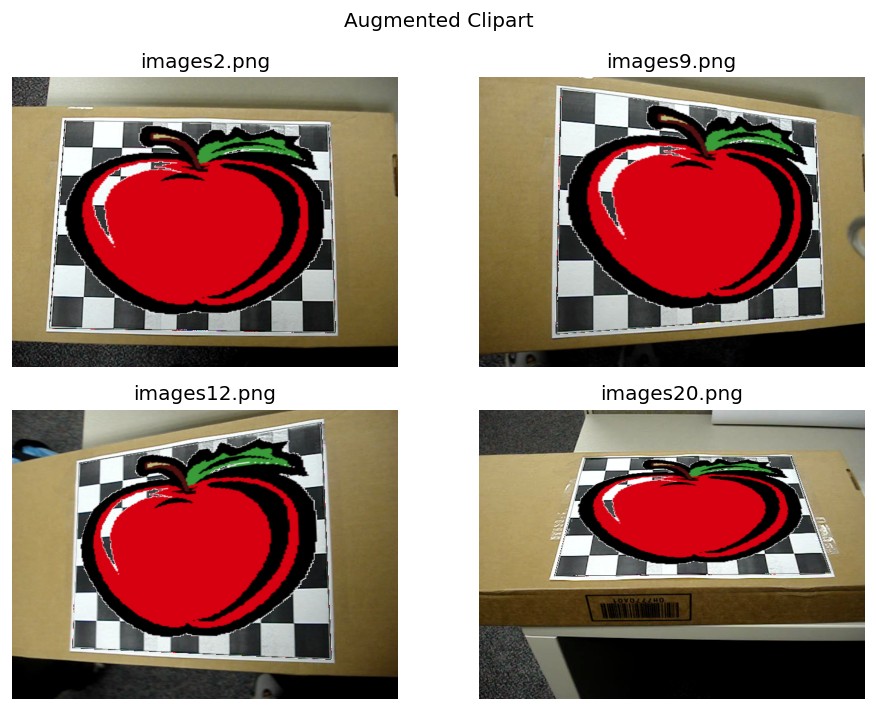

In [5]:
# Augmenting an image

%matplotlib inline
fig, axs = plt.subplots(2,math.ceil(len(images)/2))
fig.set_size_inches(8,6)
fig.set_dpi(120.0)
fig.suptitle('Augmented Clipart')
j = 0

for i, image in enumerate(images):
    if(i/2 == 1):
        j += 1

    img = cv2.imread(images_folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_copy = copy.copy(img)

    pts_dst = H_rect_mat[i] @ real_coords
    pts_dst = np.divide(pts_dst, np.tile(pts_dst[-1], (pts_dst.shape[0], 1)))
    pts_dst = pts_dst[:-1,:].T
    
    s = clip_image.shape[:-1]
    pts_src = np.array([[0, s[0] - 1 ],
                        [s[1] - 1, s[0] -1],
                        [s[1] - 1, 0],
                        [0,0]],dtype=float)
    
    h, mask = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC,5.0)
    proj_clip = cv2.warpPerspective(clip_image, h, (img.shape[1],img.shape[0]))

    r,c,a = np.where(proj_clip == 255)
    cv2.fillConvexPoly(img, pts_dst.astype(int), 0, 16)
    img = img + proj_clip
    img[r,c,:] = image_copy[r,c,:]

    axs[j, i%2].imshow(img)
    axs[j, i%2].axis('off')
    axs[j, i%2].set_title("{}".format(image))

fig.tight_layout()

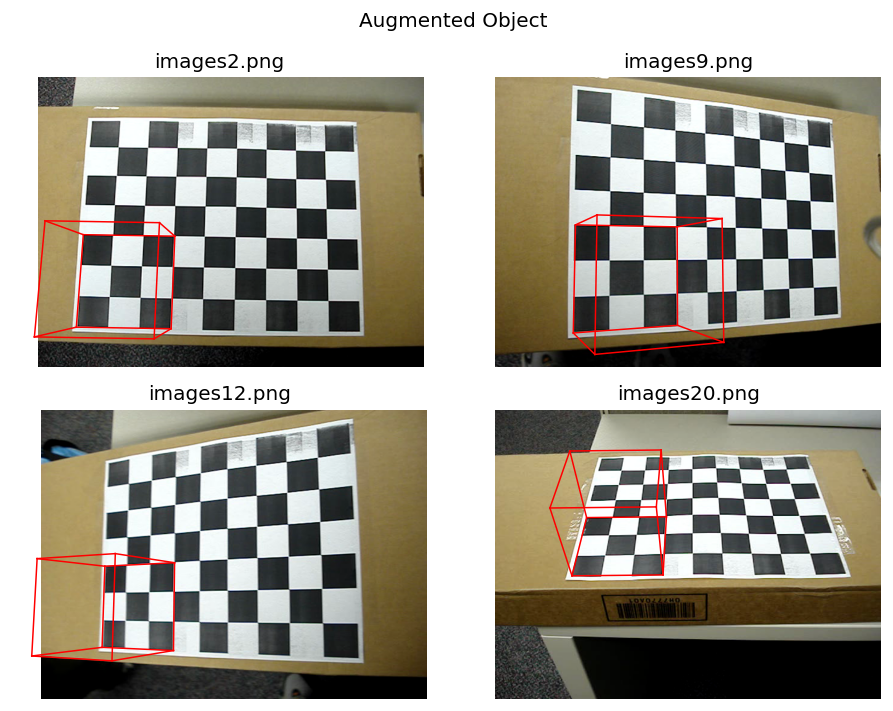

In [6]:
# Augmenting an object
%matplotlib inline
fig, axs = plt.subplots(2,math.ceil(len(images)/2))
fig.set_size_inches(8,6)
fig.set_dpi(120.0)
fig.suptitle('Augmented Object')
j = 0

cube_corners = np.array([[0, 90, 90, 0, 0, 90, 90, 0],
                [0, 0, 90, 90, 0, 0, 90, 90],
                [0, 0, 0, 0, 90, 90, 90, 90],
                [1, 1, 1, 1, 1, 1, 1, 1]], dtype=np.float32)
n_corners = cube_corners.shape[1]

for i, image in enumerate(images):
    if(i/2 == 1):
        j += 1
    
    img = cv2.imread(images_folder+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    extrinsic = np.hstack((R_list[i], t_list[i].reshape((3,1))))
    P = K @ extrinsic
    img_coords = P @ cube_corners
    img_coords = np.divide(img_coords, np.tile(img_coords[-1], (img_coords.shape[0], 1)))
    img_coords = np.transpose(img_coords[:-1,:])

    axs[j, i%2].imshow(img)
    axs[j, i%2].plot(img_coords[0:2,0], img_coords[0:2,1], color='red', linewidth='0.9')
    axs[j, i%2].plot(img_coords[1:3,0], img_coords[1:3,1], color='red', linewidth='0.9')
    axs[j, i%2].plot(img_coords[2:4,0], img_coords[2:4,1], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[0,0], img_coords[3,0]], [img_coords[0,1], img_coords[3,1]], color='red', linewidth='0.9')
    axs[j, i%2].plot(img_coords[4:6,0], img_coords[4:6,1], color='red', linewidth='0.9')
    axs[j, i%2].plot(img_coords[5:7,0], img_coords[5:7,1], color='red', linewidth='0.9')
    axs[j, i%2].plot(img_coords[6:8,0], img_coords[6:8,1], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[4,0], img_coords[7,0]], [img_coords[4,1], img_coords[7,1]], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[0,0], img_coords[4,0]], [img_coords[0,1], img_coords[4,1]], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[1,0], img_coords[5,0]], [img_coords[1,1], img_coords[5,1]], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[2,0], img_coords[6,0]], [img_coords[2,1], img_coords[6,1]], color='red', linewidth='0.9')
    axs[j, i%2].plot([img_coords[3,0], img_coords[7,0]], [img_coords[3,1], img_coords[7,1]], color='red', linewidth='0.9')
    #axs[j, i%2].plot(img_coords[5], img_coords[6], marker = 'o', color='red')
    # axs[j, i%2].scatter(img_coords[:,0],img_coords[:,1])
    axs[j, i%2].axis('off')
    axs[j, i%2].set_title("{}".format(image))

fig.tight_layout()